# **ML `CAPTCHA` Images Decoder - CMPUT 466 Project**
Group Members:
*   Yuxi Chen
*   Zijie Tan
*   Lijiangnan Tian
*   Ze Hui Peng



## **1) Setup**

Import all necessary libraries, set the device and parameters

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import string
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn # for CNN and RNN
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # for KNN
from sklearn.svm import SVC # for SVM
from sklearn import metrics
from google.colab import drive

# use either CUDA with torch or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cpu


In [ ]:
# Parameters:
NUMBERS = list(string.digits)
ALPHABET = list(string.ascii_uppercase) # all lowercase characters will be converted to uppercase
TABLE = NUMBERS + ALPHABET # The table for the captcha
LEN_OF_TABLE = len(TABLE)
BATCH_SIZE = 100
LEN_OF_CAPTCHA = 6
LEARNING_RATE = 0.001

Load the data from either Google Drive or local directory

Please **modify the *data_dir* variable by yourself based on where the dataset is stored**

In [ ]:
# Load the data from the Google Drive
drive.mount('/gdrive', force_remount = True)
data_dir = Path("/gdrive/My Drive/Data/")

# path of data set for local
# data_dir = Path("./dataset")

images = list(data_dir.glob("*.jpg"))
print("Number of images found: ", len(images))

Mounted at /gdrive
Number of images found:  10000


## **2) Example of CAPTCHA Images**

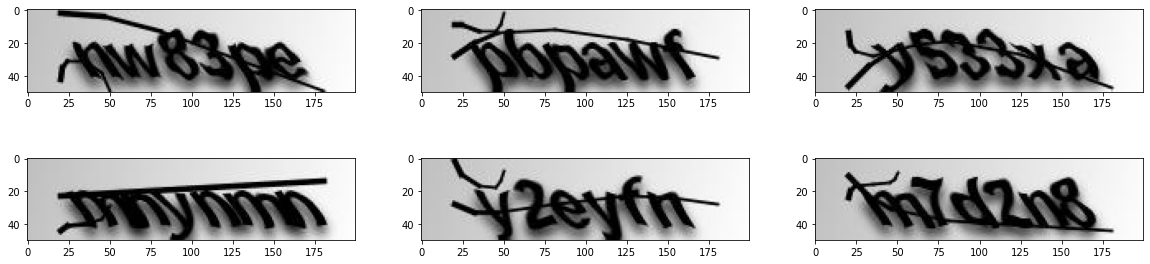

In [ ]:
sample_images = images[:6] 
_, ax = plt.subplots(2, 3, figsize=(20, 5))
for i in range(6):
    img = cv2.imread(str(sample_images[i]))
    ax[i//3, i % 3].imshow(img)
plt.show()

## **3) Preprocessing**


In [ ]:
'''
Convert the captcha into the (6 * 36,) vector (6 characters, 10 numbers + 26 uppercase characters)
1 means the captcha has this character in TABLE, 0 means not
Arg:
  captcha_str: the string that represents the sequence in the captcha image
Return:
  vector: a (6 * 36,) one hot vector 
'''
def captcha_to_vector(captcha_str):
    captcha_str = captcha_str.upper()
    vector = np.zeros(36 * 6, dtype = np.float32)
    for i, char in enumerate(captcha_str):
        ascii = ord(char)
        if ord('0') <= ascii <= ord('9'): # for numbers
            index = ascii - ord('0')
        elif ord('A') <= ascii <= ord('Z'): # for characters
            index = ascii - ord('A') + len(NUMBERS)
        vector[i * LEN_OF_TABLE + index] = 1.0
    return vector

In [ ]:
'''
Convert the vector into the captcha (the input vector is different from the vector above)
Example: 
  input: [1,2,34,2,6,7] 
  output: "23Y378"
Arg:
  vector: a vector of where each element represents a digit or uppercase letter
          element 0-9 represents digits 0-9, element 10-35 represent uppercase letters A-Z
Return:
  captcha_str: a string that decodes the vector element to its true representation
'''
def vector_to_captcha(vector):
    captcha_str = ""
    for i in vector:
        captcha_str += TABLE[i]
    return captcha_str

We have three different kinds of datasets, one is used for **CNN**, one is for **RNN**, and one is for segmentation-based algorithms (**SVM** and **KNN**)

In [ ]:
# Custom dataset used for CNN
class CustomDatasetCNN(torch.utils.data.Dataset):
    def __init__(self, images, transform = None, target_transform = None, height = 50, width = 200):
        self.transform = transform
        self.target_transform = target_transform
        self.images = images
        self.width = width
        self.height = height

    def __getitem__(self, index):
        # get the image with path
        image = cv2.imread(str(self.images[index]))
        # convert the image into grayscale
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY) 
        # resize the image to ensure the size
        image = cv2.resize(image, (self.width, self.height))
        # Binarization of images
        _, image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)

        label = captcha_to_vector(self.images[index].name.split("_")[0])
        # Apply the transform to the image
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

# Custom dataset used for RNN
class CustomDatasetRNN(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 3 chanels
        ])
        self.imgs = []
        self.labels = []
        self.imgs = dataset
        for img in self.imgs:
            self.labels.append(img.name.split("_")[0])
        self.l2 = list(string.ascii_uppercase + string.digits)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_path = self.imgs[index]
        img = Image.open(img_path)
        img = self.transform(img)
        label = self.labels[index]
        label = self.one_hot(label)
        return img, label

    def one_hot(self, label):
        vector = torch.zeros(6, 36)
        for i in range(6):
            index = self.l2.index(label[i].upper())
            vector[i][index] = 1
        return vector

# Custom dataset used for segmentation-based algorithms(i.e. SVM and KNN)
class CustomDatasetSegBased(torch.utils.data.Dataset):
    def __init__(self, images, transform=None, target_transform=None, height=50, width=200):
        self.transform = transform
        self.target_transform = target_transform
        self.images = images
        self.width = width
        self.height = height
        self.character_space = 25
    
    def noise_remover(self, image):
        # increase contrast: segmentation-based so the preprocessing is more complicated
        image = cv2.convertScaleAbs(image, alpha=3, beta=40)
        # Erode noise
        kernel = np.ones((1, 1), np.uint8)
        image = cv2.erode(image, kernel, iterations=1)
        # convert the image into grayscale
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
        # resize the image to ensure the size
        image = cv2.resize(image, (self.width, self.height))
        # Binarization of images
        _, image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
        # Method from dsp.stackexchange.com/questions/52089/removing-noisy-lines-from-image-opencv-python
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        # Shear transformation, from thepythoncode.com/article/image-transformations-using-opencv-in-python#Image_Shearing
        M = np.float32([[1, -0.5, 0],
             	          [0,    1, 0],
            	          [0,    0, 1]])
        rows, cols = image.shape #(50, 200)
        image = cv2.warpPerspective(image,M,(int(cols),int(rows)), cv2.INTER_LINEAR, borderValue=(255, 255, 255))
        # horizontal stretch
        M = np.float32([[1.2, 0, 0],
             	          [0,   1, 0],
            	          [0,   0, 1]])
        rows, cols = image.shape # (50, 200)
        image = cv2.warpPerspective(image,M,(int(cols),int(rows)), cv2.INTER_LINEAR, borderValue=(255, 255, 255))
        return image

    def character_segmenter(self, image, index):
        label = captcha_to_vector(self.images[index].name.split("_")[0])
        img_seg_list = []
        label_list = []
        # segmentation [image[:,:50], image[:,50:75], image[:,75:100], image[:,100:125], image[:,125:150], image[:,150:]]
        for j in range(LEN_OF_CAPTCHA):
          left = (j + 1) * self.character_space
          right = (j + 2) * self.character_space
          im_seg = image[:, left:right]

          # Apply the transform to the image
          if self.transform is not None:
            img_seg_list.append(self.transform(im_seg))
          else:
            img_seg_list.append(im_seg)

          label_list.append(label[j * LEN_OF_TABLE: (j + 1) * LEN_OF_TABLE])
        return img_seg_list, label_list
    
    def __getitem__(self, index):
        # get the image with path
        image = cv2.imread(str(self.images[index]))

        # remove noise from image
        image = self.noise_remover(image)

        # apply character segmentation
        (img_seg_list, label_list) = self.character_segmenter(image, index)
        return img_seg_list, label_list

    def __len__(self):
        return len(self.images)

## **4) Separate Data**

In [ ]:
# using 80% of the data for training, 20% for validation
train_data, test_data = train_test_split(images, test_size = 0.2, random_state = 6, shuffle = True)

# for segmentation-free algorithms(Neural Networks), 25% of the training data are used for validations
train_data_segfree, validation_data = train_test_split(train_data, test_size = 0.25, random_state = 6, shuffle = True)

print("test set size:", len(test_data))
print("validation set size:", len(validation_data))
print("train set size for segmentation-free algorithms:", len(train_data_segfree))
print("train set size for segmentation-based algorithms:", len(train_data))

# CustomDataset and DataLoader class for CNN
train_set_cnn = CustomDatasetCNN(train_data_segfree, transform = transforms.ToTensor())
valid_set_cnn = CustomDatasetCNN(validation_data, transform = transforms.ToTensor())
test_set_cnn = CustomDatasetCNN(test_data, transform = transforms.ToTensor())
train_dataloader_cnn = DataLoader(dataset = train_set_cnn, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader_cnn = DataLoader(dataset = valid_set_cnn, batch_size = 1, shuffle = True)
valid_dataloader_cnn = DataLoader(dataset = test_set_cnn, batch_size = 1, shuffle = True)

# CustomDataset and DataLoader class for RNN
train_set_rnn = CustomDatasetRNN(train_data_segfree)
valid_set_rnn = CustomDatasetRNN(validation_data)
test_set_rnn = CustomDatasetRNN(test_data)
train_dataloader_rnn = DataLoader(dataset = train_set_rnn, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader_rnn = DataLoader(dataset = valid_set_rnn, batch_size = 1, shuffle = True)
valid_dataloader_rnn = DataLoader(dataset = test_set_rnn, batch_size = 1, shuffle = True)

# CustomDataset and DataLoader class for segmentation-based algorithms (SVM and KNN)
train_set_segbased = CustomDatasetSegBased(train_data, transform=transforms.ToTensor())
test_set_segbased = CustomDatasetSegBased(test_data, transform=transforms.ToTensor())

train_dataloader_segbased = DataLoader(dataset = train_set_segbased, batch_size = 1, shuffle = True)
test_dataloader_segbased  = DataLoader(dataset = test_set_segbased,  batch_size = 1, shuffle = True)

test set size: 2000
validation set size: 2000
train set size for segmentation-free algorithms: 6000
train set size for segmentation-based algorithms: 8000


## **5) Example of CAPTCHA Images after preprocessing**

Example images for **segmentation-free** dataset preprocessing

(Origin $\to$ Grayscale $\to$ Binarization)

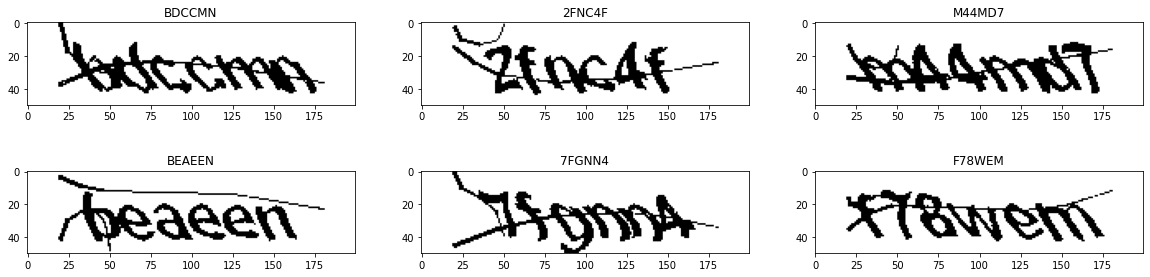

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(20, 5))
for i in range(6):
    image, label = next(iter(test_dataloader_cnn))
    image = image.to(device)
    label = label.to(device)
    label = label.reshape(LEN_OF_CAPTCHA, LEN_OF_TABLE)
    label = torch.argmax(label, dim = 1)
    origin = vector_to_captcha(label)

    image = image.reshape(50, 200).cpu()
    ax[i // 3, i % 3].imshow(image, cmap = plt.cm.gray)
    ax[i // 3, i % 3].title.set_text(origin)
plt.show()

Example image for **segmentation-based** dataset preprocessing

(Original $\to$ Erosion $\to$ Grayscale $\to$ Binarization $\to$ Morph $\to$ Shear $\to$ Stretch $\to$ Segmentation)

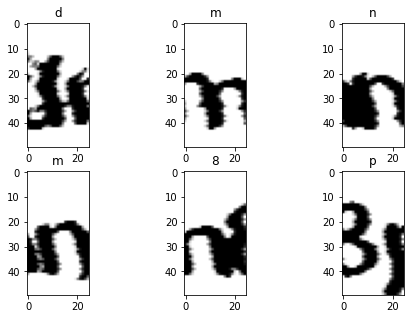

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(8, 5))
i = 0
img, lbl = next(iter(test_dataloader_segbased))
for image, label in zip(img, lbl):
    image = image.to(device)
    label = label.to(device)
    label = label.reshape(1, LEN_OF_TABLE)
    label = torch.argmax(label, dim=1)
    origin = vector_to_captcha(label).lower()

    image = image.reshape(image.shape[2], image.shape[3]).cpu()
    ax[i // 3, i % 3].imshow(image, cmap=plt.cm.gray)
    ax[i // 3, i % 3].title.set_text(origin)
    i += 1
plt.show()

## **6) Segmentation-Free Algorithms**

### **6.1) Neural Network Classifier**
A common classifier used for both Convolutional Neural Network (**CNN**) and Recurrent Neural Network (**RNN**)

In [ ]:
class NNClassifier():
    def __init__(self, epoch, criterion, learning_rate):
        self.epoch = epoch
        self.criterion = criterion
        self.learning_rate = learning_rate

    def train(self, model, train_dataloader, valid_dataloader, device):
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
        for epoch in range(self.epoch):
            model.train()
            for i, (images, labels) in enumerate(train_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                predict = model(images)
                optimizer.zero_grad()
                loss = self.criterion(predict, labels)
                loss.backward()
                optimizer.step()
            accuracy = self.test_and_validate(model, valid_dataloader, device)
            print("epoch: {} loss: {:.10f} accuracy: {:.2f}%".format((epoch + 1), loss.item(), accuracy))
  
    def test_and_validate(self, model, dataloader, device):
        num_correct = 0  # the counter for the correct items
        num_total = len(dataloader)  # the counter for the total items
        model.eval()  # set the evaluation state of the model
        with torch.no_grad():
            for _, (images, labels) in enumerate(dataloader):
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                labels = labels.reshape(LEN_OF_CAPTCHA, LEN_OF_TABLE)
                output = output.reshape(LEN_OF_CAPTCHA, LEN_OF_TABLE)
                # get the captcha character index
                labels = torch.argmax(labels, dim=1)
                # get the predict character index
                output = torch.argmax(output, dim=1)
                num_correct += ((labels == output).sum() == 6).sum().item()
            accuracy = num_correct / num_total * 100
            return accuracy

    

### **6.2) Covolutional Neural Network (CNN)**

CNN Model class

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=5, padding=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer5 = nn.Linear(64*3*12, 512)
        self.out = nn.Linear(512, 36*6)

    def forward(self, x):
        x = self.layer1(x)  # Input: torch.Size([100, 1, 50, 200])
        x = self.layer2(x)  # Input: torch.Size([100, 32, 25, 100])
        x = self.layer3(x)  # Input: torch.Size([100, 48, 12, 50])
        x = self.layer4(x)  # Input: torch.Size([100, 64, 6, 25])

        # Output: torch.Size([100, 64, 3, 12])
        x = x.view(-1, 64*3*12)
        x = self.layer5(x)
        output = self.out(x)
        # Output: torch.Size([100, 36*6])
        return output

Training and Testing CNN

In [ ]:
# Initialize the model 
model = CNN().to(device)

# Initialize the classifier
cnnClf = NNClassifier(15, nn.MultiLabelSoftMarginLoss(), LEARNING_RATE)

print("CNN Training")
cnnClf.train(model, train_dataloader_cnn, valid_dataloader_cnn, device)

print("CNN Testing")
accuracy = cnnClf.test(model, test_dataloader_cnn, device)
print("Accuracy: {}".format(accuracy))

CNN Training


KeyboardInterrupt: ignored

#### **Example predictions of CNN**

In [ ]:
model.eval()  # set the evaluation state of the model
_, ax = plt.subplots(2, 3, figsize=(20, 5))
with torch.no_grad():
    for i in range(6):
        image, label = next(iter(test_dataloader))

        image = image.to(device)
        label = label.to(device)
        output = model(image)
        label = label.reshape(LEN_OF_CAPTCHA, LEN_OF_TABLE)
        output = output.reshape(LEN_OF_CAPTCHA, LEN_OF_TABLE)
        label = torch.argmax(label, dim=1)
        output = torch.argmax(output, dim=1)
        origin = vector_to_captcha(label)
        predict = vector_to_captcha(output)

        image = image.reshape(50, 200).cpu()
        ax[i//3, i % 3].imshow(image,cmap=plt.cm.gray)
        ax[i//3, i % 3].title.set_text("Origin: "+origin+"   Predict: "+predict)
plt.show()

###  **6.3) Recurrent Neural Network (RNN)**

RNN Model Class

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(150, 128),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=200*128//5,
                            hidden_size=256,
                            num_layers=2,
                            batch_first=True)

    def forward(self, x):
        # (128, 3, 200, 50) -> (128, 150, 200)
        x = x.reshape(-1, 150, 200).permute(0, 2, 1)
        x = x.reshape(-1, 150)
        fc1 = self.fc1(x)
        fc1 = fc1.reshape(-1, 5, 200*128//5)
        lstm, (h_n, h_c) = self.lstm(fc1, None)
        out = lstm[:, -1, :]

        return out


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size=256,
                            hidden_size=128,
                            num_layers=2,
                            batch_first=True)
        self.out = nn.Linear(6*128, 6 * 36)

    def forward(self, x):
        # (N, 256) -> (N, 6, 256) -> (N, 6, 128) -> (N, 6*128) -> (N, 6* 36) -> (N, 6, 36)
        x = x.reshape(-1, 1, 256) 
        x = x.expand(-1, 6, 256)
        lstm, (h_n, h_c) = self.lstm(x, None)
        y1 = lstm.reshape(-1, 6*128)
        out = self.out(y1)
        output = out.reshape(-1, 6, 36)
        return output


class RNN (nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)

        return decoder

Training and Testing RNN

In [ ]:
# Initialize the model 
model = RNN().to(device)

# Initialize the classifier
rnnClf = NNClassifier(100, nn.MSELoss(), LEARNING_RATE)

print("RNN Training")
rnnClf.train(model, train_dataloader_rnn, valid_dataloader_rnn, device)

print("RNN Testing")
accuracy = rnnClf.test(model, test_dataloader_rnn, device)
print("Accuracy: {}".format(accuracy))

#### **Example predictions of RNN**

In [ ]:
model.eval()  # set the evaluation state of the model
_, ax = plt.subplots(2, 3, figsize=(30, 15))
with torch.no_grad():
    for i in range(6):
        image, label = next(iter(test_dataloader))

        image = image.to(device)
        label = label.to(device)
        output = model(image)
        label = label.reshape(6, 36)
        output = output.reshape(6, 36)
        label = torch.argmax(label, dim=1)
        output = torch.argmax(output, dim=1)
        origin = vector_to_captcha(label)
        predict = vector_to_captcha(output)

        image = image.reshape(50, 200)
        image = image.cpu()
        ax[i//5, i % 5].imshow(image)
        ax[i//5, i % 5].title.set_text("Origin: "+origin+" Predict: "+predict)
plt.show()

## **7) Segmentation-Based Algorithms**

### **7.1) Helper functions**

In [ ]:
def get_data(dataloader):
  X = []
  Y = []
  n = len(dataloader)
  for z in range(n):
    img, lbl = next(iter(dataloader))
    for image, label in zip(img, lbl):
      image = image.to(device)
      label = label.to(device)
      label = label.reshape(1, LEN_OF_TABLE)
      label = torch.argmax(label, dim=1)
      label = vector_to_captcha(label)
      image = image.reshape(image.shape[2], image.shape[3]).cpu()
      X.append(image.flatten().tolist())
      Y.append(label)
  return X, Y

# Groups the original and the predicted characters together to into CAPTCHAs
def group(old_list):
    n = len(old_list)
    i = 0
    new_list = []
    for i in range(0, n, LEN_OF_CAPTCHA):
        captcha = old_list[i:i+LEN_OF_CAPTCHA]
        new_list.append(''.join(captcha))
    return new_list

### **7.2) Support Vector Machine (SVM)**
Training and Testing SVM using `SVC` class from *sklearn*

In [ ]:
# Code in this cell is from kaggle.com/sanesanyo/digit-recognition-using-svm-with-98-accuracy
# Creating our linear SVM object
clf = SVC(C=1,kernel="linear")

print("SVM Training")
train_x, train_y = get_data(train_dataloader_segbased)
clf.fit(train_x, train_y)

print("SVM Testing")
test_x, test_y = get_data(test_dataloader_segbased)
y_predict = clf.predict(test_x)
# group the original and the predicted characters together to a CAPTCHA
test_y = group(test_y)
y_predict = group(y_predict)

accuracy = metrics.accuracy_score(test_y, y_predict)
print("Accuracy: {:.2f}%".format(accuracy*100))

#### **Example predictions of SVM**

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(20, 5))
for p in range(6):
    i, l = next(iter(test_dataloader_segbased))
    img = np.zeros((50,150))
    j = 0
    predicts = []
    origins = []
    for image, label in zip(i, l):
        image = image.to(device)
        image = image.reshape(1,image.shape[2]* image.shape[3]).cpu()
        predict = clf.predict(image)
        predicts.append(predict[0])
        img[:,j:j+25] = image.reshape(50,25)
        j += 25
        label = label.to(device)
        label = label.reshape(1, 36)
        label = torch.argmax(label, dim=1)
        origin = vector_to_captcha(label)
        origins.append(origin)
    ax[p // 3, p % 3].imshow(img,cmap=plt.cm.gray)
    ax[p // 3, p % 3].title.set_text("Original: "+"".join(origins)+"    Predict: "+"".join(predicts))
plt.show()

### **7.3) $k$-Nearest Neigbours(KNN)**
Training and Testing KNN using `KNeighborsClassifier` class from *sklearn*

In [ ]:
train_x, train_y = get_data(train_dataloader_segbased)
test_x, test_y = get_data(test_dataloader_segbased)
test_y = group(test_y)

for i in range(1, 15):
    knn_clf = KNeighborsClassifier(n_neighbors = i, weights = "uniform")
    print("Training KNN with k = {}".format(i))
    knn_clf.fit(train_x, train_y)
    print("Testing KNN with k = {}".format(i))
    y_predict = knn_clf.predict(test_x)
    y_predict = group(y_predict)

    accuracy=metrics.accuracy_score(test_y, y_predict)
    print("number of neighbors = {}, Accuracy: {:.2f}%".format(i, accuracy*100))

#### **Example predictions of KNN**
with $k = 5$

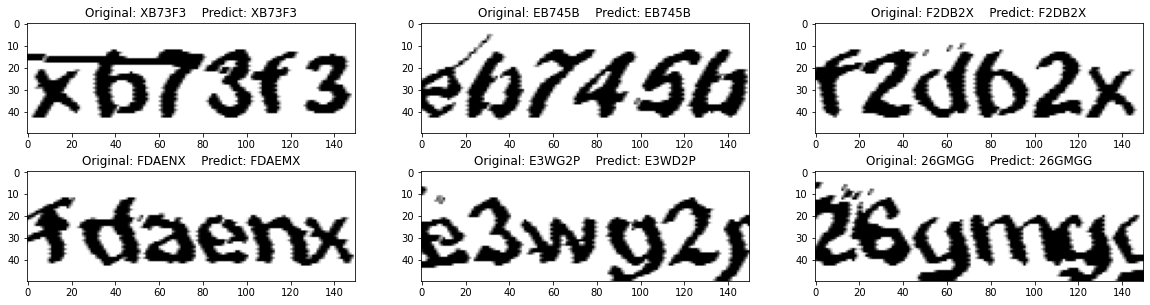

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors = 5, weights = "uniform")
train_x, train_y = get_data(train_dataloader_segbased) # run this if previous cell is not run
knn_clf.fit(train_x, train_y)

_, ax = plt.subplots(2, 3, figsize=(20, 5))
for p in range(6):
    i, l = next(iter(test_dataloader_segbased))
    img = np.zeros((50,150))
    j = 0
    predicts = []
    origins = []
    for image, label in zip(i, l):
        image = image.to(device)
        image = image.reshape(1,image.shape[2]* image.shape[3]).cpu()
        predict = knn_clf.predict(image)
        predicts.append(predict[0])
        img[:,j:j+25] = image.reshape(50,25)
        j += 25
        label = label.to(device)
        label = label.reshape(1, 36)
        label = torch.argmax(label, dim=1)
        origin = vector_to_captcha(label)
        origins.append(origin)
    ax[p // 3, p % 3].imshow(img,cmap=plt.cm.gray)
    ax[p // 3, p % 3].title.set_text("Original: "+"".join(origins)+"    Predict: "+"".join(predicts))
plt.show()